In [1]:
# generic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# project specific custom libraries
from config import *
from simulation import simulate_decay_times, smear_decay_times
from analysis import *

from joblib import delayed, Parallel

In [2]:
#set a seed for numpys random number generator
np.random.seed(1998)

In [3]:
t_bounds = [0, 20000e-9]
n = 10000
n_sims = 1000

MUON_estimate = 2e-6
PION_estimate = 1.2e-8
initial_guess = [MUON_estimate, PION_estimate]

sigmas_mult = np.array([1/100, 1/10, 1])
sigmas = sigmas_mult * PION_MEAN_LIFETIME

In [4]:
def simulation(n, t_bounds, initial_guess, sigma, bins=150):

    simulated_decay_points = simulate_decay_times(n, t_bounds[1])
    simulated_decay_points = smear_decay_times(simulated_decay_points, sigma=sigma)
    counts, bins = np.histogram(simulated_decay_points[:, 0] , bins=150, density=False)

    return binned_maximum_likelihood_fit_2(counts, bins, initial_guess)

/var/folders/wr/nnzrl8p15wd8_8sccj0_s_rc0000gn/T/ipykernel_6602/2650871027.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:218: RuntimeWarning: invalid value encountered in log
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:218: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:218: RuntimeWarning: invalid value encountered in multiply
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:218: RuntimeWarning: invalid value encountered in log
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/tillboehringer/Dro

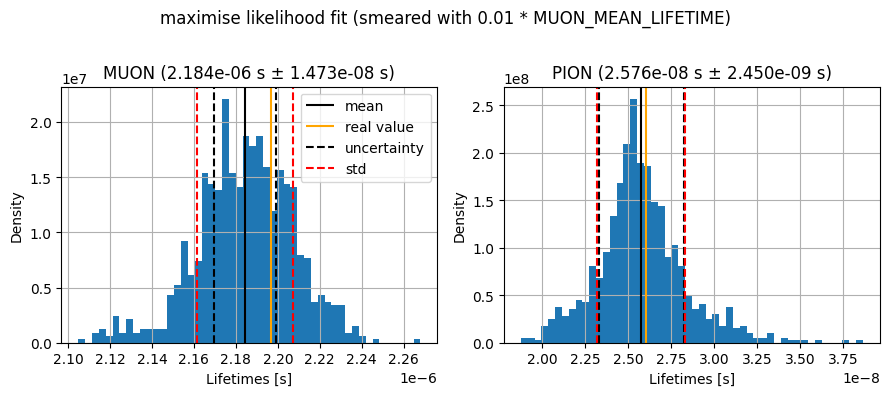

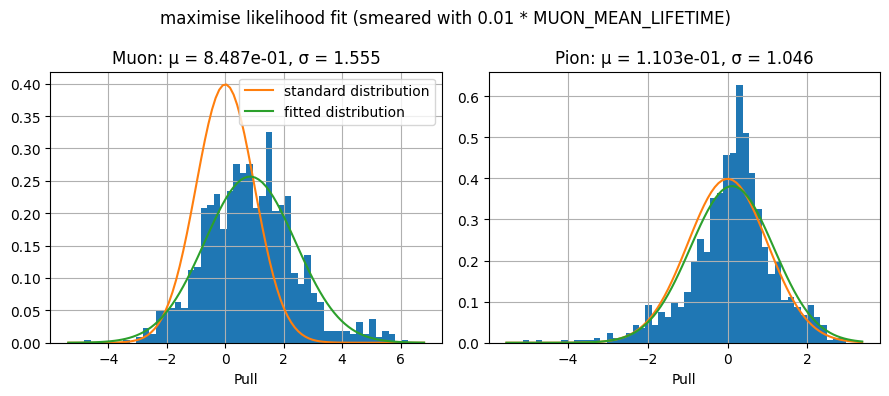

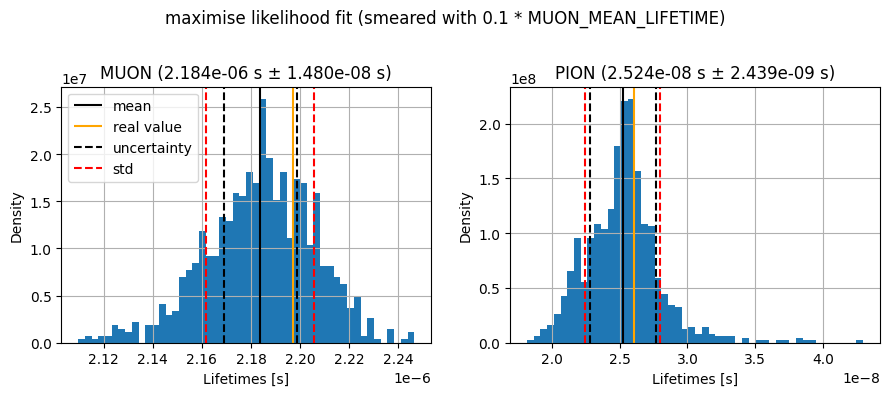

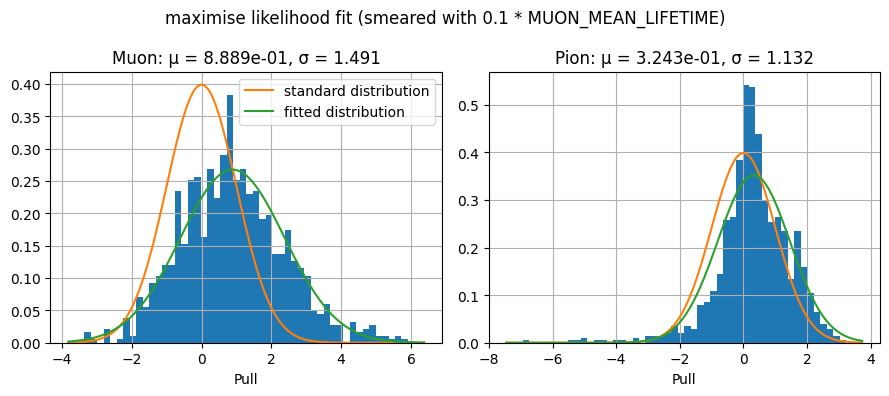

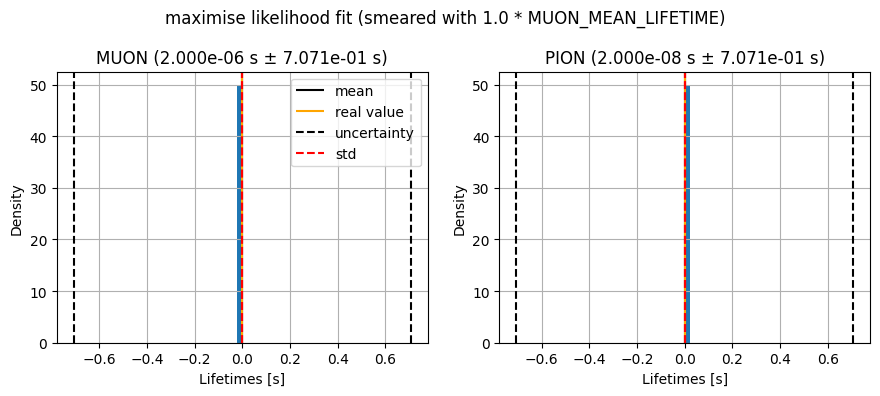

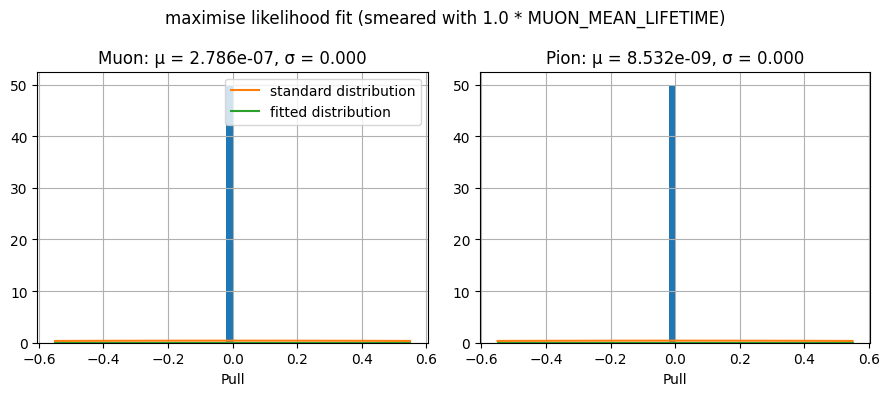

In [5]:
for j, sigma in enumerate(sigmas):
    simulation_results = Parallel(n_jobs=-1)(delayed(simulation)(n, t_bounds, initial_guess, sigma=sigma) for _ in range(n_sims))

    simulation_results = pd.DataFrame(np.array(simulation_results), columns=['MUON_estimate', 'PION_estimate', 'MUON_uncer', 'PION_uncer'])
    simulation_results.replace([np.inf, -np.inf], np.nan, inplace=True)
    simulation_results.dropna(inplace=True)
    simulation_results = simulation_results[simulation_results['MUON_estimate']>0]
    simulation_results = simulation_results[simulation_results['PION_estimate']>0]
    simulation_results = simulation_results[simulation_results['MUON_estimate']>simulation_results['PION_estimate']]

    MUON_mean = simulation_results['MUON_estimate'].mean()
    PION_mean = simulation_results['PION_estimate'].mean()
    MUON_uncer = np.sqrt(np.mean(np.power(simulation_results['MUON_uncer'],2)))
    PION_uncer = np.sqrt(np.mean(np.power(simulation_results['PION_uncer'],2)))
    MUON_std = simulation_results['MUON_estimate'].std()
    PION_std = simulation_results['PION_estimate'].std()

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
    simulation_results.hist(column=['MUON_estimate'], ax=ax[0], bins=50, density=True)
    simulation_results.hist(column=['PION_estimate'], ax=ax[1], bins=50, density=True)
    for i in ax:
        i.set_ylabel('Density')
        i.set_xlabel('Lifetimes [s]')
        i.set_ylim(i.get_ylim())

    ax[0].vlines(MUON_mean, *ax[0].get_ylim(), color='k', label='mean')
    ax[1].vlines(PION_mean, *ax[1].get_ylim(), color='k')

    ax[0].vlines(MUON_MEAN_LIFETIME, *ax[0].get_ylim(), color='orange', label='real value')
    ax[1].vlines(PION_MEAN_LIFETIME, *ax[1].get_ylim(), color='orange')

    ax[0].vlines([MUON_mean + MUON_uncer, MUON_mean - MUON_uncer], *ax[0].get_ylim(), color='k', linestyle='--', label='uncertainty')
    ax[1].vlines([PION_mean + PION_uncer, PION_mean - PION_uncer], *ax[1].get_ylim(), color='k', linestyle='--')

    ax[0].vlines([MUON_mean + MUON_std, MUON_mean - MUON_std], *ax[0].get_ylim(), color='r', linestyle='--', label='std')
    ax[1].vlines([PION_mean + PION_std, PION_mean - PION_std], *ax[1].get_ylim(), color='r', linestyle='--')

    ax[0].set_title(f'MUON ({MUON_mean:.3e} s ± {MUON_uncer:.3e} s)')
    ax[1].set_title(f'PION ({PION_mean:.3e} s ± {PION_uncer:.3e} s)')

    fig.suptitle(f'maximise likelihood fit (smeared with {sigmas_mult[j]} * MUON_MEAN_LIFETIME)')
    ax[0].legend()
    plt.tight_layout()
    fig.savefig(f'../Documentation/images/4b_hist_{j}_likelihood.pdf')
    fig.show()

    MUON_pull = pull(MUON_MEAN_LIFETIME, simulation_results['MUON_estimate'], MUON_uncer)
    PION_pull = pull(PION_MEAN_LIFETIME, simulation_results['PION_estimate'], PION_uncer)

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,4))

    fig.suptitle(f'maximise likelihood fit (smeared with {sigmas_mult[j]} * MUON_MEAN_LIFETIME)')

    for i in ax:
        # i.set_ylabel('Density')
        i.set_xlabel('Pull')
        i.grid()

    ax[0].set_title(f'Muon: µ = {np.mean(MUON_pull):.3e}, σ = {np.std(MUON_pull):.3f}')
    ax[1].set_title(f'Pion: µ = {np.mean(PION_pull):.3e}, σ = {np.std(PION_pull):.3f}')

    ax[0].hist(MUON_pull, bins=50, density=True)
    ax[1].hist(PION_pull, bins=50, density=True)

    ts_muon = np.linspace(*ax[0].get_xlim(),100)
    ax[0].plot(ts_muon, norm.pdf(ts_muon), label='standard distribution')
    ax[0].plot(ts_muon, norm.pdf(ts_muon, np.mean(MUON_pull), np.std(MUON_pull)), label='fitted distribution')

    ts_pion = np.linspace(*ax[1].get_xlim(),100)
    ax[1].plot(ts_pion, norm.pdf(ts_pion))
    ax[1].plot(ts_pion, norm.pdf(ts_pion, np.mean(PION_pull), np.std(PION_pull)))

    ax[0].legend()
    plt.tight_layout()
    fig.savefig(f'../Documentation/images/4b_pull_{j}_likelihood.pdf')